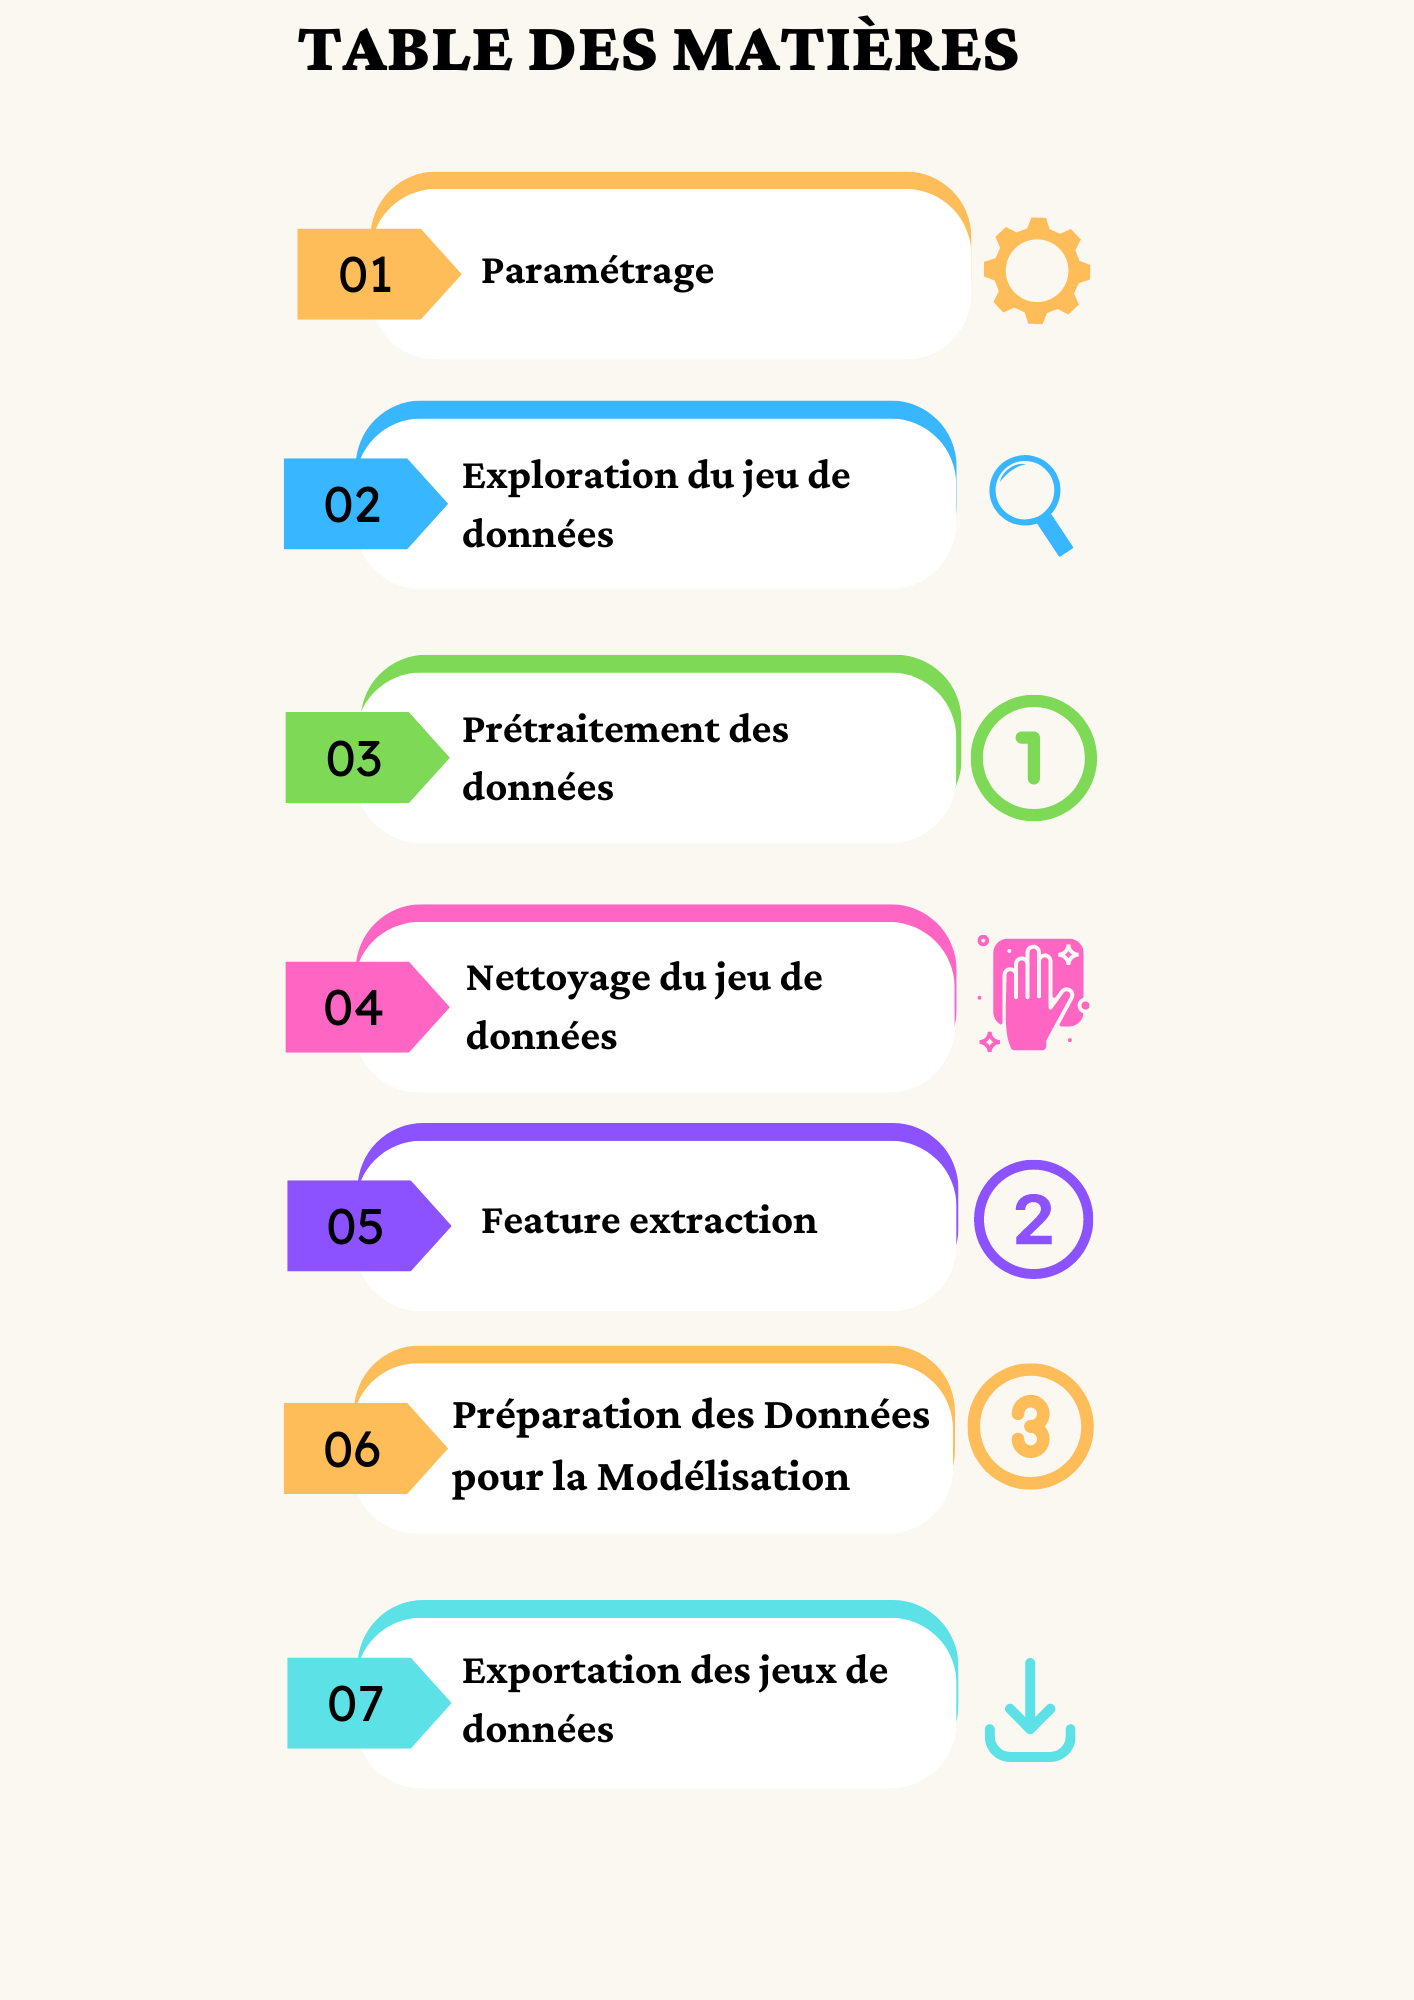

# Paramétrage

## Importation des librairies

In [ ]:
import pandas as pd
from math import ceil
import numpy as np
import psutil

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

from scipy import stats
from scipy.sparse import save_npz

from gensim.models import Word2Vec

from transformers import BertTokenizer, TFBertModel

import tensorflow as tf

from tqdm import tqdm

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import gc

from collections import Counter

import warnings

import time

from scipy import sparse as sp

from sklearn.datasets import load_digits
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, MultinomialNB, GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                   RepeatedStratifiedKFold, cross_validate)
from sklearn.metrics import (confusion_matrix, classification_report,
                           accuracy_score, roc_curve, precision_recall_curve,
                           auc, make_scorer, precision_score, 
                           recall_score, f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                          roc_curve, auc, precision_recall_curve)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.exceptions import ConvergenceWarning
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

import dask
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, LocalCluster, performance_report, as_completed, wait
from dask import delayed

from humanize import naturalsize

import psutil

import GPUtil

## Test du cluster de calcul

### Tests des capacités du cluster

In [ ]:
def test_cluster():
   def get_worker_info():
       import os
       import subprocess
       import tensorflow as tf
       
       info = {
           'hostname': os.uname().nodename,
           'cpu_threads': psutil.cpu_count(),
           'memory_gb': round(psutil.virtual_memory().total / (1024**3), 1),
           'gpu': [],
           'compute_capacity': {}
       }
       
       # Test CPU performance
       def cpu_bench():
           start = time.time()
           _ = [i**2 for i in range(10**6)]
           return time.time() - start
           
       info['compute_capacity']['cpu'] = round(1/cpu_bench(), 2)
       
       # Test ML & DL
       try:
           # GPU info
           cmd = ['nvidia-smi', '--query-gpu=name,memory.total,memory.used,temperature.gpu,compute_mode', '--format=csv,noheader,nounits']
           output = subprocess.check_output(cmd).decode()
           for line in output.strip().split('\n'):
               name, total, used, temp, compute = line.split(',')
               
               # GPU benchmark
               if tf.test.is_built_with_cuda():
                   with tf.device('/GPU:0'):
                       start = time.time()
                       _ = tf.random.normal([1000, 1000]) @ tf.random.normal([1000, 1000])
                       gpu_speed = time.time() - start
               else:
                   gpu_speed = 0
               
               info['gpu'].append({
                   'name': name.strip(),
                   'memory_total': float(total),
                   'memory_used': float(used),
                   'temperature': float(temp),
                   'compute_mode': compute.strip(),
                   'gpu_bench_score': round(1/gpu_speed, 2) if gpu_speed > 0 else 0
               })
       except Exception as e:
           info['gpu_error'] = str(e)
       
       return info

   client = Client('tcp://192.168.1.126:8786')
   try:
       for worker in client.scheduler_info()['workers']:
           print(f"\n=== Worker: {worker} ===")
           future = client.submit(get_worker_info, pure=False, workers=[worker])
           try:
               info = future.result(timeout=120)
               print(f"Hostname: {info['hostname']}")
               print(f"CPU threads: {info['cpu_threads']}")
               print(f"RAM: {info['memory_gb']} GB")
               print(f"CPU Score: {info['compute_capacity'].get('cpu', 'N/A')} ops/s")
               
               if info.get('gpu_error'):
                   print(f"GPU Error: {info['gpu_error']}")
               elif info['gpu']:
                   for gpu in info['gpu']:
                       print(f"GPU: {gpu['name']}")
                       print(f"VRAM: {gpu['memory_total']}MB ({gpu['memory_used']}MB used)")
                       print(f"Temp: {gpu['temperature']}°C")
                       print(f"Compute Mode: {gpu['compute_mode']}")
                       print(f"GPU Score: {gpu['gpu_bench_score']} ops/s")
               else:
                   print("No GPU detected")
           except Exception as e:
               print(f"Error: {str(e)}")
   finally:
       client.close()

In [ ]:
test_cluster()

### Tests de calculs

In [ ]:
from dask.distributed import Client
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from sklearn.datasets import load_digits

def test_ml_dl():
    print("=== Test ML/DL Cluster ===")
    client = Client('tcp://192.168.1.126:8786')
    
    workers = list(client.scheduler_info()['workers'].keys())
    local = next(w for w in workers if '192.168.1.126' in w)
    remote = next(w for w in workers if '192.168.1.126' not in w)

    digits = load_digits()
    X = digits.data / 16.0
    y = digits.target
    
    # Test ML
    print("\nTest Machine Learning...")
    def train_rf():
        rf = RandomForestClassifier(n_estimators=10)
        model = rf.fit(X, y)
        score = model.score(X, y)
        return score

    future_ml_local = client.submit(train_rf, workers=[local])
    future_ml_remote = client.submit(train_rf, workers=[remote])
    
    print(f"Score ML local: {future_ml_local.result():.3f}")
    print(f"Score ML distant: {future_ml_remote.result():.3f}")
    
    # Test DL
    print("\nTest Deep Learning...")
    def train_simple_nn():
        X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
        y_tensor = tf.convert_to_tensor(y, dtype=tf.int32)
        
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(32, input_shape=(64,)),
            tf.keras.layers.Dense(10)
        ])
        
        model.compile(
            optimizer=tf.keras.optimizers.SGD(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        
        history = model.fit(X_tensor, y_tensor, epochs=1)
        return float(history.history['accuracy'][-1])

    print("Test DL sur worker local...")
    future_dl = client.submit(train_simple_nn, workers=[local])
    print(f"Score DL: {future_dl.result():.3f}")
    
    client.close()
    print("\n=== Tests terminés ===")

In [ ]:
test_ml_dl()

### Paramétrage du cluster de calcul

In [ ]:
from distributed import Client

def configure_gpu():
   import tensorflow as tf
   import socket
   
   hostname = socket.gethostname()
   gpus = tf.config.list_physical_devices('GPU')
   
   if gpus:
       try:
           is_main = '192.168.1.126' in socket.gethostbyname(hostname)
           memory_limit = 10240 if is_main else 4096
           n_threads = 4 if is_main else 2
           
           for gpu in gpus:
               tf.config.set_logical_device_configuration(
                   gpu,
                   [tf.config.LogicalDeviceConfiguration(memory_limit=memory_limit)]
               )
           print(f"\n=== Configuration GPU ===")
           print(f"Machine: {'Principale' if is_main else 'Distante'}")
           print(f"GPU: {gpu.name}")
           print(f"Mémoire allouée: {memory_limit}MB")
           print(f"Threads: {n_threads}")
           print("======================\n")
       except RuntimeError as e:
           print(f"Erreur GPU: {e} ❌")

client = Client("tcp://192.168.1.126:8786")
result = client.run(configure_gpu)
print("Configuration terminée sur tous les workers ✅")

## Importation du jeu de données

Lors de la lecture du fichier CSV, les colonnes n'étaient pas correctement nommées, entraînant une mauvaise interprétation des données. 

Pour résoudre ce problème, nous nous sommes référés à la documentation Kaggle du dataset **Sentiment140** disponible ici [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/datasets/kazanova/sentiment140) et avons spécifié explicitement les noms des colonnes lors de la lecture du fichier.

In [ ]:
# Chemin relatif vers le fichier CSV
file_path = "../Data/training.1600000.processed.noemoticon.csv"

# Convertir en chemin absolu
file_path = os.path.abspath(file_path)
print(f"Chemin absolu du fichier : {file_path}")

# Vérifie l'existence du fichier
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Fichier non trouvé : {file_path}")

# Charger les données avec Pandas
data = pd.read_csv(
    file_path,
    encoding='ISO-8859-1',
    names=['target', 'ids', 'date', 'flag', 'user', 'text'],
    dtype={
        'target': 'int64',
        'ids': 'int64',
        'date': 'object',
        'flag_original': 'object',
        'user': 'object',
        'text': 'object'
    }
)

# Exploration du jeu de données

## Affichage des cinq premières lignes de notre DataFrame

In [ ]:
data.head()

## Liste des colonnes du DataFrame 

In [ ]:
data.columns.tolist()

## Affichage les informations de notre DataFrame

In [ ]:
data.info()

## Affichage du nombre de lignes et de colonnes dans le Data Frame

In [ ]:
print("Nombre de colonnes :", data.shape[1])
print("Nombre de lignes :", data.shape[0])

## Affichage des types de données de chaque colonne

In [ ]:
print("Types de données :")
data.dtypes

# Prétraitement des données

## Tokenisation

In [ ]:
def preprocess_text(text):
    tokens = word_tokenize(text, language='english')
    tokens = [token.lower() for token in tokens if token.isalpha()]
    return tokens

# Appliquer la fonction preprocess_text à chaque tweet
data['preprocessed_text'] = data['text'].apply(preprocess_text)

In [ ]:
def plot_word_frequencies(text_tokens, title, ax):
    freq_dist = nltk.FreqDist(text_tokens)
    words = [word for word, freq in freq_dist.most_common(20)]
    frequencies = [freq for word, freq in freq_dist.most_common(20)]
    ax.bar(words, frequencies, color='b')
    ax.set_title(title)
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels(words, rotation=90, ha="right")

# Combinez tous les tokens en une seule liste
all_tokens = [token for sublist in data['preprocessed_text'] for token in sublist]

# Créer la figure et les axes
fig, axs = plt.subplots(1, 1, figsize=(14, 5))
plot_word_frequencies(all_tokens, 'Fréquences des mots - Tweets prétraités', axs)
plt.tight_layout()
plt.show()

# Nettoyage du jeu de données

## Affichage du pourcentage de valeurs manquantes par colonne

In [ ]:
(data.isnull().mean() * 100).astype(int)

## Detection des doublons

In [ ]:
# Spécifiez les colonnes pertinentes pour la vérification des doublons
columns_to_check = ['target', 'ids', 'date', 'flag', 'user', 'text']

duplicates = data[data.duplicated(subset=columns_to_check)]

if len(duplicates) > 0:
    print("Notre jeu de données contient", len(duplicates), "doublon(s).")
else:
    print("Notre jeu de données ne contient pas de doublons.")

## Élimination des stopwords

### Via lemmatiseur

In [ ]:
# Initialiser le lemmatiseur
lemmatizer = WordNetLemmatizer()

# Fonction pour lemmatiser les tokens en éliminant les stopwords
def lemmatize_tokens(tokens):
    stop_words = set(stopwords.words('english'))
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return lemmatized_tokens

# Application de la fonction de lemmatisation aux tweets pré-traités
data['lemmatized_text'] = data['preprocessed_text'].apply(lemmatize_tokens)

# Afficher les résultats pour vérification
print(data[['text', 'preprocessed_text', 'lemmatized_text']].head())

### Via Stemmer

In [ ]:
# Initialiser le stemmer
stemmer = PorterStemmer()

# Fonction pour appliquer le stemming aux tokens
def stem_tokens(tokens):
    stop_words = set(stopwords.words('english'))
    stemmed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return stemmed_tokens

# Application de la fonction de stemming aux tweets pré-traités
data['stemmed_text'] = data['preprocessed_text'].apply(stem_tokens)

# Afficher les résultats pour vérification
print(data[['text', 'preprocessed_text', 'stemmed_text']].head())

### Comparaison des fréquences en fonction des méthodes de nettoyage

In [ ]:
# Fonction pour comparer les fréquences des mots avant et après une transformation
def plot_word_frequencies_compare(counter_before, counter_after, title_before, title_after):
    words_before, frequencies_before = zip(*counter_before.most_common(20))
    words_after, frequencies_after = zip(*counter_after.most_common(20))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.bar(words_before, frequencies_before, color='blue')
    ax1.set_title(title_before)
    ax1.set_xticks(range(len(words_before)))
    ax1.set_xticklabels(words_before, rotation=45, ha="right")
    
    ax2.bar(words_after, frequencies_after, color='green')
    ax2.set_title(title_after)
    ax2.set_xticks(range(len(words_after)))
    ax2.set_xticklabels(words_after, rotation=45, ha="right")
    
    plt.tight_layout()
    plt.show()

# Calculer les fréquences des mots avant et après stemming
counter_before_stemming = Counter([word for tokens in data['preprocessed_text'] for word in tokens])
counter_after_stemming = Counter([word for tokens in data['stemmed_text'] for word in tokens])

# Calculer les fréquences des mots avant et après lemmatisation
counter_before_lemmatization = Counter([word for tokens in data['preprocessed_text'] for word in tokens])
counter_after_lemmatization = Counter([word for tokens in data['lemmatized_text'] for word in tokens])

# Utilisation de la fonction pour comparer les fréquences avant et après stemming
plot_word_frequencies_compare(counter_before_stemming, counter_after_stemming,
                              "Fréquences des mots dans les tweets avant stemming", 
                              "Fréquences des mots dans les tweets après stemming")

# Utilisation de la fonction pour comparer les fréquences avant et après lemmatisation
plot_word_frequencies_compare(counter_before_lemmatization, counter_after_lemmatization,
                              "Fréquences des mots dans les tweets avant lemmatisation", 
                              "Fréquences des mots dans les tweets après lemmatisation")

# Feature extraction

In [ ]:
data.columns.tolist()

## Sous-échantillonnage

In [ ]:
def sample_with_dask(data, sample_size, random_state):
    """
    Sous-échantillonnage optimisé avec Dask
    """
    print("Préparation du sous-échantillonnage...")
    
    # Analyse des classes
    print("Analyse des classes...")
    class_counts = data['target'].value_counts()
    n_per_class_frac = sample_size
    
    # Taille des chunks pour le traitement
    chunk_size = 100000
    
    samples = []
    for cls in class_counts.index:
        print(f"\nTraitement classe {cls}...")
        print(f"- Nombre d'échantillons original: {class_counts[cls]}")
        
        # Filtrer les données pour cette classe
        class_data = data[data['target'] == cls]
        
        # Découper en chunks
        n_chunks = len(class_data) // chunk_size + 1
        class_samples = []
        
        for i in range(n_chunks):
            start_idx = i * chunk_size
            end_idx = min((i + 1) * chunk_size, len(class_data))
            
            if start_idx >= len(class_data):
                break
                
            print(f"  Chunk {i+1}/{n_chunks} (indices {start_idx}-{end_idx})")
            
            # Créer un DataFrame Dask pour ce chunk
            chunk = class_data.iloc[start_idx:end_idx]
            ddf_chunk = dd.from_pandas(chunk, npartitions=2)
            
            try:
                # Échantillonner ce chunk
                sample_chunk = ddf_chunk.sample(frac=n_per_class_frac, random_state=random_state+i)
                sample_computed = sample_chunk.compute()
                class_samples.append(sample_computed)
                
                print(f"  ✓ Chunk traité: {len(sample_computed)} échantillons")
                
                # Nettoyage mémoire
                client.run(gc.collect)
                
            except Exception as e:
                print(f"  ⚠️ Erreur sur chunk {i+1}: {str(e)}")
                continue
        
        if class_samples:
            # Combiner les chunks de cette classe
            class_result = pd.concat(class_samples)
            samples.append(class_result)
            print(f"✓ Classe {cls} terminée: {len(class_result)} échantillons")
    
    if not samples:
        raise ValueError("Échec de l'échantillonnage - aucune donnée traitée")
    
    # Assemblage final
    print("\nAssemblage final des résultats...")
    data_small = pd.concat(samples)
    
    # Mélange final
    data_small = data_small.sample(frac=1, random_state=random_state)
    
    print("\nRésultats finaux:")
    print(f"Taille du dataset original: {len(data):,}")
    print(f"Taille de l'échantillon ({sample_size*100}%): {len(data_small):,} lignes")
    print(f"Distribution finale des classes:")
    print(data_small['target'].value_counts(normalize=True))
    
    return data_small

In [ ]:
data_small = sample_with_dask(data, sample_size=0.1, random_state=42)

In [ ]:
data_small.columns.tolist()

## Représentation vectorielle du texte

### Bag of Words (BoW)

In [ ]:
import time
import ast
import gc
from dask.distributed import Client
import dask.dataframe as dd
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

def process_bow_with_dask_batched(data_small, client, config):
    """
    Traitement BOW optimisé avec Dask et par lots
    """
    print("Début du traitement BOW...")
    print(f"Taille des données initiales: {data_small.shape}")
    
    try:
        # Configuration des lots
        batch_size = 20000
        n_batches = len(data_small) // batch_size + 1
        
        # Initialisation des vectorizers
        bow_vectorizer_lemmatized = CountVectorizer(
            min_df=1,
            max_df=1.0,
            stop_words=None
        )
        bow_vectorizer_stemmed = CountVectorizer(
            min_df=1,
            max_df=1.0,
            stop_words=None
        )
        
        # Traitement des lots
        all_lemmatized_texts = []
        all_stemmed_texts = []
        
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(data_small))
            print(f"\nTraitement lot {i+1}/{n_batches} (indices {start_idx}-{end_idx})")
            
            batch = data_small.iloc[start_idx:end_idx].copy()
            
            # Conversion des textes
            start_time = time.time()
            batch['lemmatized_text_str'] = batch['lemmatized_text'].apply(
                lambda x: ' '.join(x) if isinstance(x, list) else ' '.join(ast.literal_eval(x))
            )
            batch['stemmed_text_str'] = batch['stemmed_text'].apply(
                lambda x: ' '.join(x) if isinstance(x, list) else ' '.join(ast.literal_eval(x))
            )
            print(f"Temps conversion textes: {time.time() - start_time:.2f} secondes")
            
            # Distribution du lot aux workers
            ddf_batch = dd.from_pandas(batch, npartitions=config['n_partitions'])
            
            # Récupération des textes convertis
            lemmatized_texts = ddf_batch['lemmatized_text_str'].compute()
            stemmed_texts = ddf_batch['stemmed_text_str'].compute()
            
            all_lemmatized_texts.extend(lemmatized_texts)
            all_stemmed_texts.extend(stemmed_texts)
            
            del batch, ddf_batch
            gc.collect()
            
        # Vectorisation finale
        print("\nVectorisation des textes...")
        start_time = time.time()
        bow_features_lemmatized = bow_vectorizer_lemmatized.fit_transform(all_lemmatized_texts)
        print(f"Temps vectorisation lemmatized: {time.time() - start_time:.2f} secondes")
        
        start_time = time.time()
        bow_features_stemmed = bow_vectorizer_stemmed.fit_transform(all_stemmed_texts)
        print(f"Temps vectorisation stemmed: {time.time() - start_time:.2f} secondes")
        
        # Création des DataFrames
        print("\nCréation des DataFrames...")
        df_bow_lemmatized = pd.DataFrame.sparse.from_spmatrix(
            bow_features_lemmatized,
            columns=bow_vectorizer_lemmatized.get_feature_names_out()
        ).add_prefix('lem_bow_')
        
        df_bow_stemmed = pd.DataFrame.sparse.from_spmatrix(
            bow_features_stemmed,
            columns=bow_vectorizer_stemmed.get_feature_names_out()
        ).add_prefix('stem_bow_')
        
        # Ajout des métadonnées
        print("Ajout des métadonnées...")
        ids = data_small['ids'].values
        target = data_small['target'].values
        
        df_bow_lemmatized['id'] = ids
        df_bow_lemmatized['target'] = target
        df_bow_stemmed['id'] = ids
        df_bow_stemmed['target'] = target
        
        print("\n✅ Traitement BOW terminé")
        print(f"Dimensions lemmatized: {df_bow_lemmatized.shape}")
        print(f"Dimensions stemmed: {df_bow_stemmed.shape}")
        
        return df_bow_lemmatized, df_bow_stemmed, bow_vectorizer_lemmatized, bow_vectorizer_stemmed
        
    except Exception as e:
        print(f"Erreur pendant le traitement: {str(e)}")
        print(f"Type d'erreur: {type(e)}")
        import traceback
        traceback.print_exc()
        raise

# Fonction de vérification du cluster
def check_cluster_status(client):
    print("\nÉtat du cluster:")
    print(f"Workers disponibles: {len(client.scheduler_info()['workers'])}")
    
    total_memory = 0
    total_threads = 0
    
    for worker, info in client.scheduler_info()['workers'].items():
        memory_gb = info['memory_limit'] / 1e9
        total_memory += memory_gb
        total_threads += info['nthreads']
        
        print(f"\nWorker {worker}:")
        print(f"- Mémoire totale: {memory_gb:.2f} GB")
        print(f"- CPU: {info['nthreads']} threads")
    
    print(f"\nTotal cluster:")
    print(f"- Mémoire totale: {total_memory:.2f} GB")
    print(f"- Threads totaux: {total_threads}")

# Utilisation
def run_bow_processing(data_small, client, config):
    # Vérification du cluster
    check_cluster_status(client)
    
    # Affichage des informations sur les données
    print("\nInformations sur les données:")
    print(f"Taille du DataFrame: {data_small.shape}")
    print(f"Mémoire utilisée: {data_small.memory_usage().sum() / 1024**2:.2f} MB")
    print("\nExemple de données:")
    print(data_small[['lemmatized_text', 'stemmed_text']].head())
    
    # Exécution du traitement
    return process_bow_with_dask_batched(data_small, client, config)

In [ ]:
df_bow_lemmatized, df_bow_stemmed, vectorizer_lem, vectorizer_stem = run_bow_processing(
    data_small=data_small,
    client=client,
    config={'n_partitions': 8}
)

### TF-IDF

In [ ]:
def process_tfidf_with_dask(data_small, client, config):
    """
    Traitement TF-IDF vraiment distribué avec Dask
    """
    print("Début du traitement TF-IDF...")
    
    # Division en chunks pour traitement distribué
    chunk_size = len(data_small) // len(client.scheduler_info()['workers'])
    
    def process_chunk(df):
        # Convertir les textes
        df = df.copy()
        df['lemmatized_text_str'] = df['lemmatized_text'].apply(
            lambda x: ' '.join(x) if isinstance(x, list) else ' '.join(ast.literal_eval(x))
        )
        df['stemmed_text_str'] = df['stemmed_text'].apply(
            lambda x: ' '.join(x) if isinstance(x, list) else ' '.join(ast.literal_eval(x))
        )
        return df
    
    # Distribution du traitement
    print(f"Distribution sur {len(client.scheduler_info()['workers'])} workers...")
    futures = []
    for i in range(0, len(data_small), chunk_size):
        chunk = data_small.iloc[i:i+chunk_size]
        future = client.submit(process_chunk, chunk)
        futures.append(future)
    
    # Attente des résultats
    print("Traitement distribué en cours...")
    results = client.gather(futures)
    processed_data = pd.concat(results)
    
    # Vectorisation distribuée
    print("Préparation de la vectorisation TF-IDF...")
    tfidf_vectorizer_lemmatized = TfidfVectorizer()
    tfidf_vectorizer_stemmed = TfidfVectorizer()
    
    # Fit sur toutes les données
    print("Fit des vectorizers...")
    tfidf_vectorizer_lemmatized.fit(processed_data['lemmatized_text_str'])
    tfidf_vectorizer_stemmed.fit(processed_data['stemmed_text_str'])
    
    def transform_chunk(vectorizer, texts):
        return vectorizer.transform(texts)
    
    # Distribution du transform
    print("Distribution de la transformation...")
    lemmatized_futures = []
    stemmed_futures = []
    
    for i in range(0, len(processed_data), chunk_size):
        chunk_lem = processed_data['lemmatized_text_str'].iloc[i:i+chunk_size]
        chunk_stem = processed_data['stemmed_text_str'].iloc[i:i+chunk_size]
        
        future_lem = client.submit(transform_chunk, tfidf_vectorizer_lemmatized, chunk_lem)
        future_stem = client.submit(transform_chunk, tfidf_vectorizer_stemmed, chunk_stem)
        
        lemmatized_futures.append(future_lem)
        stemmed_futures.append(future_stem)
        print(f"Envoyé chunk {i//chunk_size + 1}/{(len(processed_data) + chunk_size - 1)//chunk_size}")
    
    # Récupération et combinaison des résultats
    print("Combinaison des résultats...")
    tfidf_features_lemmatized = sp.vstack(client.gather(lemmatized_futures))
    tfidf_features_stemmed = sp.vstack(client.gather(stemmed_futures))
    
    print("Création des DataFrames...")
    df_tfidf_lemmatized = pd.DataFrame.sparse.from_spmatrix(
        tfidf_features_lemmatized,
        columns=tfidf_vectorizer_lemmatized.get_feature_names_out()
    ).add_prefix('lem_tfidf_')
    
    df_tfidf_stemmed = pd.DataFrame.sparse.from_spmatrix(
        tfidf_features_stemmed,
        columns=tfidf_vectorizer_stemmed.get_feature_names_out()
    ).add_prefix('stem_tfidf_')
    
    # Métadonnées
    df_tfidf_lemmatized['id'] = processed_data['ids'].values
    df_tfidf_lemmatized['target'] = processed_data['target'].values
    df_tfidf_stemmed['id'] = processed_data['ids'].values
    df_tfidf_stemmed['target'] = processed_data['target'].values
    
    print("✅ Traitement TF-IDF terminé")
    print(f"Dimensions lemmatized: {df_tfidf_lemmatized.shape}")
    print(f"Dimensions stemmed: {df_tfidf_stemmed.shape}")
    
    return df_tfidf_lemmatized, df_tfidf_stemmed, tfidf_vectorizer_lemmatized, tfidf_vectorizer_stemmed

In [ ]:
df_tfidf_lemmatized, df_tfidf_stemmed, vectorizer_tfidf_lem, vectorizer_tfidf_stem = process_tfidf_with_dask(
    data_small, 
    client, 
    {'n_partitions': 10}
)

## Word Embeddings

### Word2Vec

In [ ]:
def ensure_client(scheduler_address='tcp://192.168.1.126:8786', max_retries=3):
   """Vérifie la connexion client et tente de la rétablir si nécessaire"""
   for attempt in range(max_retries):
       try:
           client = Client(scheduler_address)
           client.scheduler_info()
           return client
       except Exception as e:
           if attempt == max_retries - 1:
               raise Exception(f"Impossible de se connecter au scheduler après {max_retries} tentatives")
           print(f"Tentative de reconnexion {attempt + 1}/{max_retries}...")
           time.sleep(2)

def process_word2vec_with_dask(data_small, client, config):
    """
    Traitement Word2Vec optimisé avec Dask pour un cluster avec gestion des erreurs
    """
    print("Début du traitement Word2Vec...")
    
    try:
        # Vérification de la connexion
        if not client or not client.scheduler:
            print("Client non connecté, tentative de reconnexion...")
            client = ensure_client()
        
        n_workers = len(client.scheduler_info()['workers'])
        print(f"Nombre de workers disponibles: {n_workers}")
        
        # Diviser les données en chunks plus petits
        chunk_size = len(data_small) // (n_workers * 2) 
        print(f"Taille des chunks: {chunk_size}")
        
        lemmatized_models = []
        stemmed_models = []
        
        # Traitement par chunks
        for i in range(0, len(data_small), chunk_size):
            chunk = data_small.iloc[i:i+chunk_size]
            print(f"\nTraitement chunk {i//chunk_size + 1}/{(len(data_small) + chunk_size - 1)//chunk_size}")
            
            # Entrainement local des modèles pour ce chunk
            print("Entrainement des modèles sur le chunk...")
            lem_model = Word2Vec(
                sentences=chunk['lemmatized_text'].values.tolist(),
                vector_size=100,
                window=5,
                min_count=1,
                workers=4
            )
            lemmatized_models.append(lem_model)
            
            stem_model = Word2Vec(
                sentences=chunk['stemmed_text'].values.tolist(),
                vector_size=100,
                window=5,
                min_count=1,
                workers=4
            )
            stemmed_models.append(stem_model)
        
        # Fusionner les vocabulaires et mettre à jour les vecteurs
        print("\nFusion des modèles...")
        word2vec_model_lemmatized = lemmatized_models[0]
        word2vec_model_stemmed = stemmed_models[0]
        
        for model in lemmatized_models[1:]:
            word2vec_model_lemmatized.wv.vectors = np.vstack([word2vec_model_lemmatized.wv.vectors, model.wv.vectors])
            word2vec_model_lemmatized.wv.index_to_key.extend(model.wv.index_to_key)
        
        for model in stemmed_models[1:]:
            word2vec_model_stemmed.wv.vectors = np.vstack([word2vec_model_stemmed.wv.vectors, model.wv.vectors])
            word2vec_model_stemmed.wv.index_to_key.extend(model.wv.index_to_key)
            
        print("Calcul des embeddings...")
        lemmatized_embeddings = []
        stemmed_embeddings = []
        
        batch_size = 1000
        for i in range(0, len(data_small), batch_size):
            batch = data_small.iloc[i:i+batch_size]
            
            lem_batch = batch['lemmatized_text'].apply(
                lambda x: np.mean([word2vec_model_lemmatized.wv[token] 
                                 for token in x if token in word2vec_model_lemmatized.wv], axis=0)
            ).tolist()
            
            stem_batch = batch['stemmed_text'].apply(
                lambda x: np.mean([word2vec_model_stemmed.wv[token] 
                                 for token in x if token in word2vec_model_stemmed.wv], axis=0)
            ).tolist()
            
            lemmatized_embeddings.extend(lem_batch)
            stemmed_embeddings.extend(stem_batch)
            
            print(f"Traité batch {i//batch_size + 1}/{(len(data_small) + batch_size - 1)//batch_size}")
        
        print("Création des DataFrames...")
        df_word2vec_lemmatized = pd.DataFrame(
            np.vstack(lemmatized_embeddings)
        ).add_prefix('word2vec_lem_')
        
        df_word2vec_stemmed = pd.DataFrame(
            np.vstack(stemmed_embeddings)
        ).add_prefix('word2vec_stem_')
        
        print("Ajout des métadonnées...")
        df_word2vec_lemmatized['id'] = data_small['ids'].values
        df_word2vec_lemmatized['target'] = data_small['target'].values
        df_word2vec_stemmed['id'] = data_small['ids'].values
        df_word2vec_stemmed['target'] = data_small['target'].values
        
        print("✅ Traitement Word2Vec terminé")
        print(f"Dimensions lemmatized: {df_word2vec_lemmatized.shape}")
        print(f"Dimensions stemmed: {df_word2vec_stemmed.shape}")
        
        return df_word2vec_lemmatized, df_word2vec_stemmed, word2vec_model_lemmatized, word2vec_model_stemmed
                
    except Exception as e:
        print(f"Erreur lors du traitement: {str(e)}")
        raise

In [ ]:
try:
    client = ensure_client()
    df_word2vec_lemmatized, df_word2vec_stemmed, vectorizer_word2vec_lem, vectorizer_word2vec_stem = process_word2vec_with_dask(
        data_small,
        client,
        {'n_workers': 4, 'n_partitions': 8}
    )
except Exception as e:
    print(f"Erreur finale: {e}")

## GloVe

In [ ]:
def load_glove_embeddings(file_path):
    """
    Charge les embeddings GloVe depuis un fichier texte.
    """
    print("Chargement des embeddings GloVe...")
    embeddings_index = {}
    with open(file_path, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0] 
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Nombre de mots chargés dans GloVe: {len(embeddings_index)}")
    return embeddings_index

def calculate_mean_glove_embedding(tokens, embeddings_index, embedding_dim=100):
    """
    Calcule l'embedding moyen pour une liste de tokens.
    """
    try:
        valid_embeddings = [
            embeddings_index[token] 
            for token in tokens 
            if token in embeddings_index
        ]
        
        if valid_embeddings:
            return np.mean(valid_embeddings, axis=0)
        return np.zeros(embedding_dim)
    except Exception as e:
        print(f"Error processing tokens: {tokens[:5]}...")
        return np.zeros(embedding_dim)

def process_glove_with_dask(data_small, client, config):
    """
    Traitement GloVe distribué avec Dask
    """
    print("Début du traitement GloVe distribué...")
    
    try:
        # Vérification du cluster
        n_workers = len(client.scheduler_info()['workers'])
        print(f"Nombre de workers disponibles: {n_workers}")
        
        # Chargement des embeddings GloVe
        print("Chargement des embeddings GloVe...")
        glove_file_path = './GloVe/glove.6B.100d.txt'
        glove_embeddings = load_glove_embeddings(glove_file_path)
        
        # Conversion en DataFrame Dask
        chunk_size = len(data_small) // n_workers
        
        print("Distribution du traitement...")
        futures_lem = []
        futures_stem = []
        
        for i in range(0, len(data_small), chunk_size):
            chunk = data_small.iloc[i:i+chunk_size]
            
            # Soumission des tâches pour le batch
            future_lem = client.submit(
                lambda df: df['lemmatized_text'].apply(
                    lambda x: calculate_mean_glove_embedding(x, glove_embeddings)
                ).tolist(),
                chunk
            )
            futures_lem.append(future_lem)
            
            future_stem = client.submit(
                lambda df: df['stemmed_text'].apply(
                    lambda x: calculate_mean_glove_embedding(x, glove_embeddings)
                ).tolist(),
                chunk
            )
            futures_stem.append(future_stem)
            
            print(f"Soumis batch {i//chunk_size + 1}/{(len(data_small) + chunk_size - 1)//chunk_size}")
        
        # Récupération des résultats
        print("Collecte des résultats...")
        lemmatized_embeddings = []
        stemmed_embeddings = []
        
        for f_lem, f_stem in zip(futures_lem, futures_stem):
            lemmatized_embeddings.extend(f_lem.result())
            stemmed_embeddings.extend(f_stem.result())
        
        # Création des DataFrames
        print("Création des DataFrames...")
        df_glove_lemmatized = pd.DataFrame(lemmatized_embeddings).add_prefix('glove_lem_')
        df_glove_stemmed = pd.DataFrame(stemmed_embeddings).add_prefix('glove_stem_')
        
        # Ajout des métadonnées
        df_glove_lemmatized['id'] = data_small['ids'].values
        df_glove_lemmatized['target'] = data_small['target'].values
        df_glove_stemmed['id'] = data_small['ids'].values
        df_glove_stemmed['target'] = data_small['target'].values
        
        print("✅ Traitement GloVe terminé")
        print(f"Dimensions lemmatized: {df_glove_lemmatized.shape}")
        print(f"Dimensions stemmed: {df_glove_stemmed.shape}")
        
        return df_glove_lemmatized, df_glove_stemmed
        
    except Exception as e:
        print(f"Erreur lors du traitement: {str(e)}")
        raise

In [ ]:
try:
    df_glove_lemmatized, df_glove_stemmed = process_glove_with_dask(
        data_small,
        client,
        {'n_partitions': 8}
    )
except Exception as e:
    print(f"Erreur finale: {e}")

## Fine-Tuning des Modèles Pré-entraînés

In [ ]:
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = TFBertModel.from_pretrained(bert_model_name)

def get_bert_embeddings(texts, max_length=512):
    # Répartition selon VRAM disponible
    client = Client('tcp://192.168.1.126:8786')
    workers = list(client.scheduler_info()['workers'])
    
    powerful_batch = 16 
    main_batch = 8
    
    embeddings = []
    for i in tqdm(range(0, len(texts)), desc="Processing"):
        if i % 2 == 0:
            batch_size = powerful_batch 
        else:
            batch_size = main_batch
            
        batch = texts[i:i + batch_size]
        encoded = bert_tokenizer(
            batch,
            return_tensors='tf',
            padding=True,
            truncation=True,
            max_length=max_length
        )
        output = bert_model(encoded)
        embeddings.extend(output.pooler_output.numpy())
        
    client.close()
    return embeddings


try:
    bert_embeddings_lemmatized = get_bert_embeddings(lemmatized_texts)
    bert_embeddings_stemmed = get_bert_embeddings(stemmed_texts)
    

    if bert_embeddings_lemmatized:
        df_bert_lemmatized = pd.DataFrame(bert_embeddings_lemmatized).add_prefix('bert_lem_') 
        df_bert_lemmatized['id'] = data_small['ids'].values
        df_bert_lemmatized['target'] = data_small['target'].values
        
    if bert_embeddings_stemmed:
        df_bert_stemmed = pd.DataFrame(bert_embeddings_stemmed).add_prefix('bert_stem_')
        df_bert_stemmed['id'] = data_small['ids'].values
        df_bert_stemmed['target'] = data_small['target'].values
        
    print("Distribution (lemmatized):\n", df_bert_lemmatized['target'].value_counts())
    print("\nDistribution (stemmed):\n", df_bert_stemmed['target'].value_counts())
    
except Exception as e:
    print(f"Error: {str(e)}")

# Préparation des Données pour la Modélisation

## Gestion des déséquilibres de classe

In [ ]:
data["target"].unique()

In [ ]:
data_small["target"].unique()

In [ ]:
# Fonction pour afficher le graph
def plot_pie_chart(y, title):
    counter = Counter(y)
    labels, sizes = zip(*counter.items())
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=[f'Classe {label}' for label in labels], autopct='%1.1f%%', startangle=140, colors=['skyblue', 'orange', 'green'])
    plt.title(title)
    plt.show()

# Afficher la répartition des classes dans le dataset complet
plot_pie_chart(data['target'], "Répartition des classes dans le dataset complet")

# Afficher la répartition des classes dans le dataset réduit
plot_pie_chart(data_small['target'], "Répartition des classes dans le dataset réduit")

# Modélisation

## Verifications de nos données

In [ ]:
# Dictionnaire des DataFrames à inspecter avec leurs noms
dfs = {
    'df_bow_lemmatized': df_bow_lemmatized,
    'df_bow_stemmed': df_bow_stemmed,
    'df_tfidf_lemmatized': df_tfidf_lemmatized,
    'df_tfidf_stemmed': df_tfidf_stemmed,
    'df_word2vec_lemmatized': df_word2vec_lemmatized,
    'df_word2vec_stemmed': df_word2vec_stemmed,
    'df_bert_lemmatized': df_bert_lemmatized,
    'df_bert_stemmed': df_bert_stemmed,
    'df_glove_lemmatized': df_glove_lemmatized,
    'df_glove_stemmed': df_glove_stemmed,
    'data_small': data_small
}

# Fonction pour vérifier chaque DataFrame
def dfVerification(dfs):
    for df_name, df in dfs.items():
        print(f"DataFrame '{df_name}':")
        print(df.columns[:20].tolist())
        print("\n" + "="*50 + "\n")

dfVerification(dfs)

In [ ]:
# Fonction pour vérifier la distribution des classes dans un DataFrame donné
def check_class_distribution(df, df_name):
    print(f"\nDistribution des classes pour {df_name} :")
    if 'target' in df.columns:
        # Créer une copie pour ne pas modifier le DataFrame original
        target_col = df['target'].copy()
        
        # Vérifier et afficher les valeurs uniques avant traitement
        print("Valeurs uniques trouvées:", target_col.unique())
        
        # Convertir en numérique d'abord pour gérer les formats différents
        target_col = pd.to_numeric(target_col, errors='coerce')
        
        # Gérer les NaN si présents
        if target_col.isna().any():
            print(f"Attention: {target_col.isna().sum()} valeurs NaN trouvées")

            target_col = target_col.fillna(0)
        
        # Convertir en int
        target_col = target_col.astype(int)
        
        # Tri des valeurs pour avoir toujours le même ordre
        distribution = target_col.value_counts().sort_index()
        
        # Affichage formaté
        for class_label, count in distribution.items():
            print(f"{class_label:<5} {count}")
    else:
        print("La colonne 'target' n'est pas présente dans ce DataFrame.")

# Affichage pour les données originales
print("\nDistribution des classes dans la cible complète :")
original_dist = data['target'].value_counts().sort_index()
for class_label, count in original_dist.items():
    print(f"{class_label:<5} {count}")

# Vérification pour chaque DataFrame
dfs = {
    "Bag of Words (lemmatisé)": df_bow_lemmatized,
    "Bag of Words (stemmé)": df_bow_stemmed,
    "TF-IDF (lemmatisé)": df_tfidf_lemmatized,
    "TF-IDF (stemmé)": df_tfidf_stemmed,
    "Word2Vec (lemmatisé)": df_word2vec_lemmatized,
    "Word2Vec (stemmé)": df_word2vec_stemmed,
    "BERT (lemmatisé)": df_bert_lemmatized,
    "BERT (stemmé)": df_bert_stemmed,
    "GloVe (lemmatisé)": df_glove_lemmatized,
    "GloVe (stemmé)": df_glove_stemmed
}

for name, df in dfs.items():
    check_class_distribution(df, name)

## Préprocessing

### Standardisation (BoW/TF-IDF)

Dans notre projet, nous avons appliqué la standardisation aux représentations Bag of Words (BoW) et TF-IDF, et la normalisation aux représentations Word2Vec et BERT, afin d’optimiser les performances des modèles et de garantir une convergence efficace des algorithmes d’apprentissage.

La standardisation, qui consiste à centrer et réduire les données, est particulièrement adaptée aux représentations BoW et TF-IDF. 

Ces méthodes produisent des vecteurs de grande dimensionnalité, souvent clairsemés, où les fréquences des termes peuvent varier considérablement. 

La standardisation permet de contrôler ces variations, assurant que chaque caractéristique contribue de manière équilibrée à l’apprentissage du modèle. Cette approche est soutenue par des études démontrant que la standardisation améliore la performance des modèles de classification basés sur des représentations textuelles telles que BoW et TF-IDF.

En revanche, les représentations Word2Vec, GloVe, et BERT génèrent des vecteurs denses et de dimensionnalité fixe, où les valeurs sont souvent déjà normalisées en raison des processus d’entraînement sous-jacents. 

Cependant, une normalisation supplémentaire, telle que MaxAbs, est nécessaire pour garantir une échelle cohérente entre les dimensions, en particulier lorsqu’ils sont utilisés avec des modèles sensibles à l’échelle des données. 

Cette étape préventive améliore la convergence et la stabilité des algorithmes, tout en garantissant une interprétabilité uniforme des caractéristiques extraites. Cette approche est également soutenue par des travaux démontrant que la normalisation des embeddings améliore la performance globale des modèles de classification textuelle

[Comparing Bag of Words and TF-IDF with different models for hate speech detection from live tweets](https://link.springer.com/article/10.1007/s41870-022-01096-4)

In [ ]:
# Création du dictionnaire des DataFrames
dfs_to_standardize = {
    'bow_lemmatized': df_bow_lemmatized,
    'bow_stemmed': df_bow_stemmed,
    'tfidf_lemmatized': df_tfidf_lemmatized,
    'tfidf_stemmed': df_tfidf_stemmed
}


# Création du dictionnaire des DataFrames pour les embeddings
embedding_dfs = {
    'word2vec_lemmatized': df_word2vec_lemmatized,
    'word2vec_stemmed': df_word2vec_stemmed,
    'bert_lemmatized': df_bert_lemmatized,
    'bert_stemmed': df_bert_stemmed,
    'glove_lemmatized': df_glove_lemmatized,
    'glove_stemmed': df_glove_stemmed
}

In [ ]:
def standardize_bow_tfidf(dfs, n_components=None):
    """
    Standardise les features BoW et TF-IDF
    """
    standardized_dfs = {}
    scaler = StandardScaler(with_mean=False)
    
    print("DataFrames disponibles:", list(dfs.keys()))  # Debug
    
    for df_name, df in dfs.items():
        # Vérifier si c'est un DataFrame BOW ou TF-IDF
        if not any(method in df_name.lower() for method in ['bow', 'tfidf']):
            print(f"Ignoré: {df_name}")  # Debug
            continue
            
        print(f"\nStandardisation de {df_name}")
        print(f"Shape initiale: {df.shape}")
        
        try:
            # Vérifier les colonnes
            print(f"Colonnes disponibles: {df.columns[:5]}")  # Debug
            
            # Sauvegarder id et target
            ids = df['id'].values
            target = df['target'].values
            
            # Sélectionner les features (toutes les colonnes sauf id et target)
            features = df.drop(['id', 'target'], axis=1)
            
            # Réduire dimensionnalité si demandé
            if n_components and n_components < features.shape[1]:
                features = features.iloc[:, :n_components]
                print(f"Réduction à {n_components} features")
            
            # Standardisation
            print("Standardisation en cours...")
            features_standardized = scaler.fit_transform(features)
            
            # Créer nouveau DataFrame
            standardized_dfs[df_name] = pd.DataFrame.sparse.from_spmatrix(
                features_standardized,
                columns=[f"{df_name}_feat_{i}" for i in range(features_standardized.shape[1])]
            )
            
            # Ajouter id et target
            standardized_dfs[df_name]['id'] = ids
            standardized_dfs[df_name]['target'] = target
            
            print(f"Shape finale: {standardized_dfs[df_name].shape}")
            
            # Libérer mémoire
            del features, features_standardized
            gc.collect()
            
        except Exception as e:
            print(f"Erreur lors du traitement de {df_name}: {str(e)}")
            continue
    
    return standardized_dfs

# Application
print("Début de la standardisation...")
standardized_dfs = standardize_bow_tfidf(dfs_to_standardize, n_components=1000)

# Vérification des résultats
print("\nRésultats de la standardisation:")
for name, df in standardized_dfs.items():
    print(f"\n{name}:")
    print(f"Shape: {df.shape}")
    print(f"Mémoire utilisée: {df.memory_usage().sum() / 1024 / 1024:.2f} MB")
    print("Distribution des classes:")
    print(df['target'].value_counts())
    print("-" * 50)

### Normalisation (Word2Vec/BERT)

In [ ]:
def normalize_embeddings(dfs, embedding_types=['word2vec', 'bert', 'glove']):
    """
    Normalise les embeddings (Word2Vec, BERT, GloVe) avec gestion optimisée de la mémoire.
    """
    normalized_dfs = {}
    scaler = StandardScaler()    
    print("Début de la normalisation...")
    
    for df_name, df in dfs.items():
        # Vérifier si c'est un DataFrame d'embeddings
        if not any(emb_type in df_name.lower() for emb_type in embedding_types):
            continue
            
        print(f"\nNormalisation de {df_name}")
        print(f"Shape initiale: {df.shape}")
        
        try:
            # Sauvegarder id et target
            ids = df['id'].values
            target = df['target'].values
            
            # Sélectionner les features
            features = df.drop(['id', 'target'], axis=1)
            
            # Normalisation
            print("Normalisation en cours...")
            features_normalized = scaler.fit_transform(features)
            
            # Créer le DataFrame normalisé
            normalized_dfs[df_name] = pd.DataFrame(
                features_normalized,
                columns=[f"{df_name}_feat_{i}" for i in range(features_normalized.shape[1])]
            )
            
            # Ajouter id et target
            normalized_dfs[df_name]['id'] = ids
            normalized_dfs[df_name]['target'] = target
            
            print(f"Shape finale: {normalized_dfs[df_name].shape}")
            
            # Libérer la mémoire
            del features, features_normalized
            gc.collect()
            
        except Exception as e:
            print(f"Erreur lors du traitement de {df_name}: {str(e)}")
            continue
    
    return normalized_dfs

# Application
print("Début de la normalisation des embeddings...")
normalized_dfs = normalize_embeddings(embedding_dfs)

# Vérification des résultats
print("\nRésultats de la normalisation:")
for name, df in normalized_dfs.items():
    print(f"\n{name}:")
    print(f"Shape: {df.shape}")
    print(f"Mémoire utilisée: {df.memory_usage().sum() / 1024 / 1024:.2f} MB")
    print("Distribution des classes:")
    print(df['target'].value_counts())
    print("-" * 50)

### Séparation des DataFrames

In [ ]:
def verify_data_integrity(X_train, X_test, y_train, y_test, df_name):
    """
    Vérifie l'intégrité des données après split
    """
    print(f"\nVérification de {df_name}:")
    print(f"Shapes: X_train {X_train.shape}, X_test {X_test.shape}")
    print(f"Classes Train:", y_train.value_counts().to_dict())
    print(f"Classes Test:", y_test.value_counts().to_dict())
    
    try:
        assert len(y_train.unique()) > 1, "Train set: une seule classe"
        assert len(y_test.unique()) > 1, "Test set: une seule classe"
        assert X_train.shape[0] == len(y_train), "Incohérence X_train/y_train"
        assert X_test.shape[0] == len(y_test), "Incohérence X_test/y_test"
        assert not X_train.isnull().any().any(), "NaN dans X_train"
        assert not X_test.isnull().any().any(), "NaN dans X_test"
        return True
    except AssertionError as e:
        print(f"❌ Erreur: {str(e)}")
        return False

def split_features_target(df):
    """
    Sépare features et target avec gestion mémoire optimisée
    """
    y = df['target'].copy()
    X = df.drop(['target', 'id'] if 'id' in df.columns else ['target'], axis=1)
    return X, y

def split_train_test(df, df_name, test_size=0.2, random_state=42):
    """
    Réalise le split train/test avec gestion mémoire optimisée
    """
    try:
        print(f"\nSplit de {df_name}")
        
        X, y = split_features_target(df)
        
        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        train_idx, test_idx = next(sss.split(X, y))
        
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]
        
        if verify_data_integrity(X_train, X_test, y_train, y_test, df_name):
            del X, y
            gc.collect()
            return X_train, X_test, y_train, y_test
        return None
    
    except Exception as e:
        print(f"❌ Erreur lors du split de {df_name}: {str(e)}")
        return None

# Préparation des données pour la modélisation
print("Préparation des données...")

# Combiner les DataFrames
dfs_to_process = {
    'bow_lemmatized': df_bow_lemmatized,
    'bow_stemmed': df_bow_stemmed,
    'tfidf_lemmatized': df_tfidf_lemmatized,
    'tfidf_stemmed': df_tfidf_stemmed,
    'word2vec_lemmatized': df_word2vec_lemmatized,
    'word2vec_stemmed': df_word2vec_stemmed,
    'bert_lemmatized': df_bert_lemmatized,
    'bert_stemmed': df_bert_stemmed,
    'glove_lemmatized': df_glove_lemmatized,
    'glove_stemmed': df_glove_stemmed
}

# Traiter chaque DataFrame
splits = {}
for name, df in dfs_to_process.items():
    result = split_train_test(df, name)
    if result is not None:
        splits[name] = result
    gc.collect()

# Résumé final
print("\nRésumé du traitement:")
print(f"DataFrames traités avec succès: {len(splits)}/{len(dfs_to_process)}")
for name in splits.keys():
    X_train, X_test, y_train, y_test = splits[name]
    print(f"\n{name}:")
    print(f"Train: {X_train.shape}, Test: {X_test.shape}")
    print(f"Distribution train: {y_train.value_counts().to_dict()}")

## Étude Comparative et Analyse de Modélisation Hybride en Classification de Sentiments

In [ ]:
def create_model_comparison_plots(results_df, title="Comparaison des Performances des Modèles"):
    """
    Crée des visualisations comparatives pour différents modèles.
    
    Args:
        results_df: DataFrame avec colonnes ['Modèle', 'Représentation', 'AUC ROC', 'AUC PR', 'Accuracy']
        title: Titre du graphique
    """
    if results_df.empty:
        print("Pas de données à visualiser")
        return
        
    plt.figure(figsize=(15, 10))
    metrics = ['AUC ROC', 'AUC PR', 'Accuracy']
    
    if all(col in results_df.columns for col in ['Modèle', 'Représentation'] + metrics):
        results_melted = results_df.melt(
            id_vars=['Modèle', 'Représentation'],
            value_vars=metrics,
            var_name='Metric',
            value_name='Valeur'
        )
        
        g = sns.catplot(
            data=results_melted,
            x='Représentation',
            y='Valeur',
            hue='Metric',
            col='Modèle',
            kind='bar',
            col_wrap=2,
            height=4,
            aspect=1.5
        )
        g.fig.suptitle(title, y=1.02)
        plt.tight_layout()
        plt.show()

In [ ]:
def process_single_model(model_info, split_info, chunk_size=1000):
   """
   Traite un modèle sur un jeu de données en chunks
   """
   scoring = {
       'accuracy': 'accuracy',
       'precision': make_scorer(precision_score, average='weighted', zero_division=1),
       'recall': make_scorer(recall_score, average='weighted', zero_division=1),
       'f1': make_scorer(f1_score, average='weighted', zero_division=1),
       'roc_auc': 'roc_auc'
   }
   
   model_name, (model, param_grid) = model_info
   df_name, (X_train, X_test, y_train, y_test) = split_info
   
   try:
       print(f"\nTraitement de {df_name} avec {model_name}")
       start_time = time()
       
       # Conversion et chunking des données
       if sparse.issparse(X_train):
           X_train = sparse.csr_matrix(X_train)
           X_test = sparse.csr_matrix(X_test)
           
       y_train_binary = y_train.replace(4, 1)
       y_test_binary = y_test.replace(4, 1)

       # Cross-validation optimisée
       cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)
       grid_search = GridSearchCV(
           model, param_grid, cv=cv, scoring=scoring,
           refit='accuracy', n_jobs=2, return_train_score=True
       )
       
       # Entrainement par chunks
       for i in range(0, len(X_train), chunk_size):
           X_chunk = X_train[i:i + chunk_size]
           y_chunk = y_train_binary[i:i + chunk_size]
           grid_search.fit(X_chunk, y_chunk)
       
       best_model = grid_search.best_estimator_
       
       # Prédiction par chunks
       y_pred = []
       y_proba = []
       for i in range(0, len(X_test), chunk_size):
           X_chunk = X_test[i:i + chunk_size]
           y_pred.extend(best_model.predict(X_chunk))
           y_proba.extend(best_model.predict_proba(X_chunk)[:, 1])
           
       y_pred = np.array(y_pred)
       y_proba = np.array(y_proba)

       return {
           'Modèle': model_name,
           'Représentation': df_name,
           'AUC ROC': roc_auc_score(y_test_binary, y_proba),
           'AUC PR': average_precision_score(y_test_binary, y_proba),
           'Accuracy': accuracy_score(y_test_binary, y_pred) * 100,
           'Temps (s)': time() - start_time,
           'Meilleurs Paramètres': grid_search.best_params_
       }
       
   except Exception as e:
       print(f"❌ Erreur pour {model_name} sur {df_name}: {str(e)}")
       return None

### Approche 1 : Approches en Machine Learning

Les résultats obtenus montrent des performances élevées pour les modèles basés sur les représentations Word2Vec et BERT, avec des scores de précision, rappel et f1-score atteignant 1.00. 

En revanche, les approches classiques Bag of Words et TF-IDF produisent des performances inférieures (précision de 0.50). 

Cette disparité suggère un potentiel sur-apprentissage dans les modèles Word2Vec et BERT, pouvant résulter d’une adaptation excessive aux données d’entraînement et limitant ainsi la généralisation.

Afin de confirmer le phénomène de sur-apprentissage et d’améliorer la capacité de généralisation, nous allons optimiser l’implémentation en peaufinant les techniques de régularisation et en ajustant la complexité des modèles.

Cette approche permettra de tester la robustesse des performances en conditions variées et de garantir un modèle capable de généraliser efficacement sur de nouvelles données.

In [ ]:
# # Configuration
# warnings.filterwarnings('ignore', category=UserWarning)
# warnings.filterwarnings('ignore', category=FutureWarning)
# warnings.filterwarnings('ignore', category=ConvergenceWarning)
# sns.set_theme()

# def create_plots_with_cv_results(model_name, df_name, y_test_binary, y_pred_test, 
#                                y_proba_test, cv_results):
#     """
#     Crée les graphiques avec résultats de validation croisée
#     """
#     # Configuration des subplots
#     fig = plt.figure(figsize=(20, 12))
#     gs = fig.add_gridspec(2, 3)

#     # Rapport de classification
#     report = classification_report(
#         y_test_binary, 
#         y_pred_test, 
#         target_names=['Négatif', 'Positif'],
#         zero_division=1
#     )
#     print(f"\nRapport de classification pour {model_name} sur {df_name}:\n{report}")

#     # Affichage des résultats de validation croisée
#     print("\nRésultats de la validation croisée:")
#     metrics_results = {}
#     for metric, values in cv_results.items():
#         if metric.endswith('_test_score'):
#             metric_name = metric.replace('test_', '')
#             mean_score = values.mean()
#             std_score = values.std()
#             print(f"{metric_name}: {mean_score:.3f} (+/- {std_score * 2:.3f})")
#             metrics_results[metric_name] = values

#     # Courbe ROC
#     ax1 = fig.add_subplot(gs[0, 0])
#     fpr, tpr, _ = roc_curve(y_test_binary, y_proba_test)
#     roc_auc = auc(fpr, tpr)
    
#     ax1.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
#     ax1.plot([0, 1], [0, 1], 'k--')
#     ax1.set_xlabel("Taux de Faux Positifs")
#     ax1.set_ylabel("Taux de Vrai Positifs")
#     ax1.set_title(f"Courbe ROC - {model_name}\n{df_name}")
#     ax1.legend(loc="lower right")

#     # Courbe Precision-Recall
#     ax2 = fig.add_subplot(gs[0, 1])
#     precision, recall, _ = precision_recall_curve(y_test_binary, y_proba_test)
#     pr_auc = auc(recall, precision)

#     ax2.plot(recall, precision, label=f"AUC PR = {pr_auc:.2f}")
#     ax2.set_xlabel("Rappel")
#     ax2.set_ylabel("Précision")
#     ax2.set_title(f"Courbe Precision-Recall - {model_name}\n{df_name}")
#     ax2.legend(loc="lower left")

#     # Matrice de confusion
#     ax3 = fig.add_subplot(gs[0, 2])
#     conf_matrix = confusion_matrix(y_test_binary, y_pred_test)
#     sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
#                 xticklabels=['Négatif', 'Positif'], yticklabels=['Négatif', 'Positif'],
#                 ax=ax3)
#     ax3.set_title(f"Matrice de Confusion - {model_name}\n{df_name}")
#     ax3.set_xlabel("Prédiction")
#     ax3.set_ylabel("Vérité")

#     # Résultats de validation croisée
#     ax4 = fig.add_subplot(gs[1, :])
    
#     # Création du DataFrame pour le boxplot
#     cv_scores_data = []
#     for metric_name, scores in metrics_results.items():
#         cv_scores_data.extend([(metric_name, score) for score in scores])
    
#     cv_df = pd.DataFrame(cv_scores_data, columns=['Métrique', 'Score'])
    
#     if not cv_df.empty:
#         sns.boxplot(data=cv_df, x='Métrique', y='Score', ax=ax4)
#         ax4.set_title("Distribution des Scores de Validation Croisée")
#         ax4.set_ylim(0, 1)
#         ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
#     else:
#         ax4.text(0.5, 0.5, 'Pas de données de validation croisée disponibles',
#                 horizontalalignment='center', verticalalignment='center')
    
#     plt.tight_layout()
#     plt.show()
#     plt.close()
    
#     return roc_auc, pr_auc

# def evaluate_sentiment_models_with_cv(splits):
#     """
#     Évalue les modèles avec validation croisée répétée et multiple métriques
#     """
#     # Définition des scorers
#     scoring = {
#         'accuracy': 'accuracy',
#         'precision': make_scorer(precision_score, average='weighted', zero_division=1),
#         'recall': make_scorer(recall_score, average='weighted', zero_division=1),
#         'f1': make_scorer(f1_score, average='weighted', zero_division=1),
#         'roc_auc': 'roc_auc'
#     }

#     # Définition des modèles avec grilles d'hyperparamètres
#     models = {
#         'Dummy (most_frequent)': (
#             DummyClassifier(strategy='most_frequent'),
#             {'strategy': ['most_frequent', 'stratified']}  # Ajout d'options pour le Dummy
#         ),
#         'Multinomial Naive Bayes': (
#             Pipeline([
#                 ('scaler', StandardScaler(with_mean=False)),
#                 ('abs', FunctionTransformer(lambda x: np.abs(x))),
#                 ('nb', MultinomialNB())
#             ]),
#             {
#                 'nb__alpha': [0.1, 0.5, 1.0, 2.0],
#             }
#         ),
#         'Logistic Regression': (
#             Pipeline([
#                 ('scaler', StandardScaler(with_mean=False)),
#                 ('lr', LogisticRegression(random_state=42))
#             ]),
#             {
#                 'lr__C': [0.001, 0.01, 0.1, 1, 10],
#                 'lr__penalty': ['l1', 'l2'],
#                 'lr__solver': ['saga'],
#                 'lr__max_iter': [5000]
#             }
#         ),
#         'SVM': (
#             Pipeline([
#                 ('scaler', StandardScaler(with_mean=False)),
#                 ('svm', SVC(probability=True, random_state=42))
#             ]),
#             {
#                 'svm__C': [0.1, 1, 10],
#                 'svm__kernel': ['linear', 'rbf'],
#                 'svm__gamma': ['scale', 'auto']
#             }
#         ),
#         'Random Forest': (
#             Pipeline([
#                 ('rf', RandomForestClassifier(random_state=42))
#             ]),
#             {
#                 'rf__n_estimators': [100, 200],
#                 'rf__max_depth': [10, 15, 20],
#                 'rf__min_samples_split': [2, 5],
#                 'rf__min_samples_leaf': [1, 2]
#             }
#         ),
#         'XGBoost': (
#             Pipeline([
#                 ('xgb', XGBClassifier(
#                     random_state=42,
#                     use_label_encoder=False,
#                     eval_metric='logloss',
#                     n_jobs=-1,
#                     verbosity=0
#                 ))
#             ]),
#             {
#                 'xgb__max_depth': [3, 5, 7],
#                 'xgb__n_estimators': [100, 200],
#                 'xgb__learning_rate': [0.01, 0.1],
#                 'xgb__subsample': [0.8, 1.0],
#                 'xgb__colsample_bytree': [0.8, 1.0]
#             }
#         )
#     }
    
#     summary_results = []
    
#     # Configuration de la validation croisée répétée
#     cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    
#     # Boucle principale
#     for model_name, (model, param_grid) in tqdm(models.items(), desc="Modèles"):
#         for df_name, (X_train, X_test, y_train, y_test) in tqdm(splits.items(), 
#                                                                desc=f"Datasets pour {model_name}"):
#             try:
#                 print(f"\nTraitement de {df_name} avec {model_name}")
#                 start_time = time()
                
#                 # Conversion des données
#                 if sparse.issparse(X_train):
#                     X_train = X_train.todense()
#                     X_test = X_test.todense()
                
#                 # Conversion des labels
#                 y_train_binary = y_train.replace(4, 1)
#                 y_test_binary = y_test.replace(4, 1)

#                 # Grid Search avec validation croisée
#                 grid_search = GridSearchCV(
#                     model, 
#                     param_grid,
#                     cv=cv,
#                     scoring=scoring,
#                     refit='accuracy',
#                     n_jobs=-1,
#                     return_train_score=True,
#                     error_score='raise'
#                 )
                
#                 # Entraînement
#                 grid_search.fit(X_train, y_train_binary)
#                 best_model = grid_search.best_estimator_
                
#                 print(f"Meilleurs paramètres: {grid_search.best_params_}")
                
#                 # Validation croisée sur le meilleur modèle
#                 cv_results = cross_validate(
#                     best_model,
#                     X_train,
#                     y_train_binary,
#                     cv=cv,
#                     scoring=scoring,
#                     return_train_score=True,
#                     n_jobs=-1
#                 )

#                 # Prédictions
#                 y_pred_test = best_model.predict(X_test)
#                 y_proba_test = best_model.predict_proba(X_test)[:, 1]

#                 # Création des graphiques et calcul des métriques
#                 roc_auc, pr_auc = create_plots_with_cv_results(
#                     model_name, 
#                     df_name, 
#                     y_test_binary, 
#                     y_pred_test, 
#                     y_proba_test,
#                     cv_results
#                 )

#                 # Temps d'exécution
#                 training_time = time() - start_time

#                 # Sauvegarde des résultats
#                 cv_scores = {metric: values.mean() 
#                            for metric, values in cv_results.items() 
#                            if metric.endswith('_test_score')}
                
#                 result = {
#                     'Modèle': model_name,
#                     'Représentation': df_name,
#                     'AUC ROC': roc_auc,
#                     'AUC PR': pr_auc,
#                     'Accuracy': accuracy_score(y_test_binary, y_pred_test) * 100,
#                     'Temps (s)': training_time,
#                     'Meilleurs Paramètres': grid_search.best_params_,
#                     **cv_scores
#                 }
                
#                 summary_results.append(result)

#                 # Nettoyage mémoire
#                 gc.collect()
                
#             except Exception as e:
#                 print(f"❌ Erreur pour {model_name} sur {df_name}: {str(e)}")
#                 continue

#     # Création du DataFrame final
#     summary_df = pd.DataFrame(summary_results)
    
#     # Visualisation finale des résultats
#     plt.figure(figsize=(15, 10))
#     metrics = ['AUC ROC', 'AUC PR', 'Accuracy']
#     summary_df_melted = summary_df.melt(
#         id_vars=['Modèle', 'Représentation'],
#         value_vars=metrics,
#         var_name='Metric',
#         value_name='Valeur'
#     )
    
#     g = sns.catplot(
#         data=summary_df_melted,
#         x='Représentation',
#         y='Valeur',
#         hue='Metric',
#         col='Modèle',
#         kind='bar',
#         col_wrap=2,
#         height=4,
#         aspect=1.5
#     )
#     g.fig.suptitle("Comparaison des Performances des Modèles", y=1.02)
#     plt.tight_layout()
#     plt.show()

#     return summary_df

# summary_df = evaluate_sentiment_models_with_cv(splits)

In [ ]:
# summary_df

In [ ]:
# summary_df_sorted = summary_df.sort_values(by='Accuracy', ascending=True)

In [ ]:
# summary_df_sorted

In [ ]:
def get_model_configurations():
    """Configurations optimisées selon ressources du cluster"""
    configs = {
        'Dummy': (
            DummyClassifier(strategy='most_frequent'),
            {'strategy': ['most_frequent']}
        ),
        'NB': (
            Pipeline([
                ('scaler', StandardScaler(with_mean=False)),
                ('nb', MultinomialNB())
            ]),
            {'nb__alpha': [0.1, 1.0]}
        ),
        'LogReg': (  # Pour machine principale
            Pipeline([
                ('scaler', StandardScaler(with_mean=False)),
                ('lr', LogisticRegression(random_state=42, n_jobs=2))
            ]),
            {
                'lr__C': [0.1, 1],
                'lr__penalty': ['l2'],
                'lr__max_iter': [1000]
            }
        ),
        'RF': (  
            Pipeline([
                ('rf', RandomForestClassifier(random_state=42, n_jobs=8))
            ]),
            {
                'rf__n_estimators': [100],
                'rf__max_depth': [10, 15]
            }
        ),
        'XGB': (  
            Pipeline([
                ('xgb', XGBClassifier(
                    tree_method='gpu_hist',
                    gpu_id=0,
                    random_state=42,
                    n_jobs=4
                ))
            ]),
            {
                'xgb__max_depth': [5],
                'xgb__n_estimators': [100],
                'xgb__learning_rate': [0.1]
            }
        )
    }
    return configs

def evaluate_sentiment_models_with_cv_dask(splits):
    client = Client('tcp://192.168.1.126:8786')
    models = get_model_configurations()
    all_results = []

    # Map des workers
    workers = client.scheduler_info()['workers']
    powerful_worker = next(w for w in workers if '192.168.1.60' in w)
    main_worker = next(w for w in workers if '192.168.1.126' in w)

    # Distribution selon ressources
    model_assignment = {
        'Dummy': main_worker,
        'NB': main_worker,
        'LogReg': main_worker,
        'RF': powerful_worker,
        'XGB': powerful_worker
    }

    chunk_sizes = {
        main_worker: 50,    
        powerful_worker: 100 
    }

    for model_name, (model, params) in models.items():
        print(f"\nTraitement de {model_name}")
        worker = model_assignment[model_name]
        chunk_size = chunk_sizes[worker]
        
        futures = []
        for split_name, (X_train, X_test, y_train, y_test) in splits.items():
            future = client.submit(
                process_single_model,
                (model_name, (model, params)),
                (split_name, (X_train, X_test, y_train, y_test)),
                chunk_size,
                workers=[worker],
                pure=False
            )
            futures.append(future)
            
        try:
            results = client.gather(futures)
            all_results.extend([r for r in results if r])
        except Exception as e:
            print(f"Erreur {model_name}: {str(e)}")

    df = pd.DataFrame(all_results)
    if not df.empty:
        create_model_comparison_plots(df)
    return df

In [ ]:
summary_df = evaluate_sentiment_models_with_cv_dask(splits)

Analyse des Performances de Classification sur les Représentations Textuelles
1. Représentations Simples (BoW, TF-IDF)

Meilleures performances globales :

Logistic Regression + BoW stemmed : 71.25% (Accuracy), AUC ROC : 0.7795
Logistic Regression + TF-IDF stemmed : 71.25% (Accuracy), AUC ROC : 0.7703
Random Forest + BoW stemmed : 70.75% (Accuracy), AUC ROC : 0.7769
XGBoost + BoW stemmed : 70.75% (Accuracy), AUC ROC : 0.7798


Le stemming apporte systématiquement une amélioration par rapport à la lemmatisation
Ces représentations surpassent globalement les méthodes avancées d'embeddings

2. Word2Vec

Performances faibles : AUC ROC entre 0.58 et 0.63, Accuracy entre 55-60%
Particulièrement mauvais avec SVM (AUC ROC = 0.5000)
Les résultats suggèrent une difficulté à capter les relations contextuelles pertinentes pour cette tâche

3. GloVe

Performances moyennes : AUC ROC entre 0.70 et 0.74, Accuracy entre 66-68%
Plus stable que Word2Vec à travers les différents modèles
Amélioration notable par rapport à Word2Vec, mais reste inférieur aux représentations simples

4. BERT (Feature Extraction)

Performances compétitives : AUC ROC entre 0.70 et 0.76, Accuracy entre 66-68%
Meilleure stabilité que Word2Vec
Performances similaires à GloVe mais sans avantage significatif par rapport aux représentations simples

Conclusion

Les représentations simples (BoW, TF-IDF) combinées à la Régression Logistique, Random Forest ou XGBoost offrent les meilleures performances
Le stemming s'avère plus efficace que la lemmatisation pour toutes les approches
Les embeddings (Word2Vec, GloVe, BERT), malgré leur complexité, ne parviennent pas à surpasser les méthodes traditionnelles sur cette tâche spécifique
La Régression Logistique se montre particulièrement efficace avec les représentations BoW et TF-IDF

### Approche 2 : Approches en Deep Learning ( réseaux de neurones profonds )

	Objectif : Développer un modèle avancé basé sur des réseaux de neurones profonds.
	•	Essayer différentes méthodes d’embeddings (Word2Vec, GloVe).
	•	Entraîner un modèle de réseaux de neurones en utilisant Keras/TensorFlow.
	•	Comparaison des performances avec le modèle basique.
	•	Implémenter et évaluer un modèle BERT pour voir l’impact sur les performances.

### Approche 3 : Approches en Transfer Learning avec BERT

### Choix du model et du dataset 

## Suivi des expérimentations et tracking

	Objectif : Implémenter les principes MLOps pour le suivi et la gestion des modèles.
	•	Utiliser MLFlow pour le suivi des expérimentations.
	•	Enregistrement des résultats des différentes versions des modèles (tracking des hyperparamètres et des performances).
	•	Stockage des modèles pour permettre une gestion des versions efficace.